# Modelando as queimadas no estado do Amazonas com um modelo diferente para cada mês + Lag Features + Rolling Window + Expanding Features

<p>O objetivo aqui é extender o modelo anterior utilizando a técnica Rolling Window, ou seja, janelas deslizantes, que consiste em utilizar uma janela de valores anteriores como input para o modelo, através de alguma sumarização dos valores na janela. Por exemplo: é de se imaginar que a quantidade de incidentes no mês atual possua alguma relação com a quantidade de incidentes médios nos 6 meses anteriores, assim como é de se esperar que a quantidade de incidentes no mês atual esteja relacionado com a quantidade média de incidentes no mesmo mês, porém do ano passado e retrasado. A janela deslizante também sofre das mesmas restrições que os lag features. Um caso especial de janelas é quando vamos expandindo o tamanho delas desde o início das amostras, podendo também ser sumarizadas usando alguma conta de tendência central, desvio.</p> </br>


## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Auxiliar Functions

In [2]:
def clean_x_axis(X_test):
    date_list = []
    year_list = X_test['year'].values
    month_list = X_test['month'].values
        
    for i in range(len(X_test)):
        date_list.append(str(year_list[i])[2:] + '-' + str(month_list[i]))
        
    return date_list

## Load datasets

In [3]:
agregated_data = pd.read_csv("..\\..\\dados\\Feature Engineered\\agregated_data.csv")
# agregated_data['state'].unique()

## Prepare Data

In [4]:
state = agregated_data.loc[agregated_data['state'] == 'amazonas']
print("state len:", len(state))
state = state.sort_values('month', kind="mergesort").sort_values('year', kind="mergesort")

state len: 252


In [5]:
input_features = ['year', 'month', 'incidents_expanding_mean']
target_feature = ['incidents']

state['incidents_lagged_one_month'] = state['incidents'].shift(1)
state['incidents_lagged_one_year'] = state['incidents'].shift(12)
state['incidents_difference_between_shifts'] = state['incidents'].shift(13) - state['incidents'].shift(1)

state['incidents_rolling_mean_12_months'] = state['incidents_lagged_one_month'].rolling(12).mean()
state['incidents_rolling_mean_2_years'] = (state['incidents'].shift(12) + state['incidents'].shift(24))/2

state['incidents_expanding_mean'] = state['incidents_lagged_one_month'].expanding(1).mean()

# The simplest way to deal with the nan values generetaed by the shift function is just to drop the first year
state = state.dropna()
X, y = state[input_features], state[target_feature]

## Linear Modelling

Essa implementação considera que você só utilizará o modelo para fazer previsões um passo a frente!

### Linear Regression

442.24500000000006 0.5666666666666667


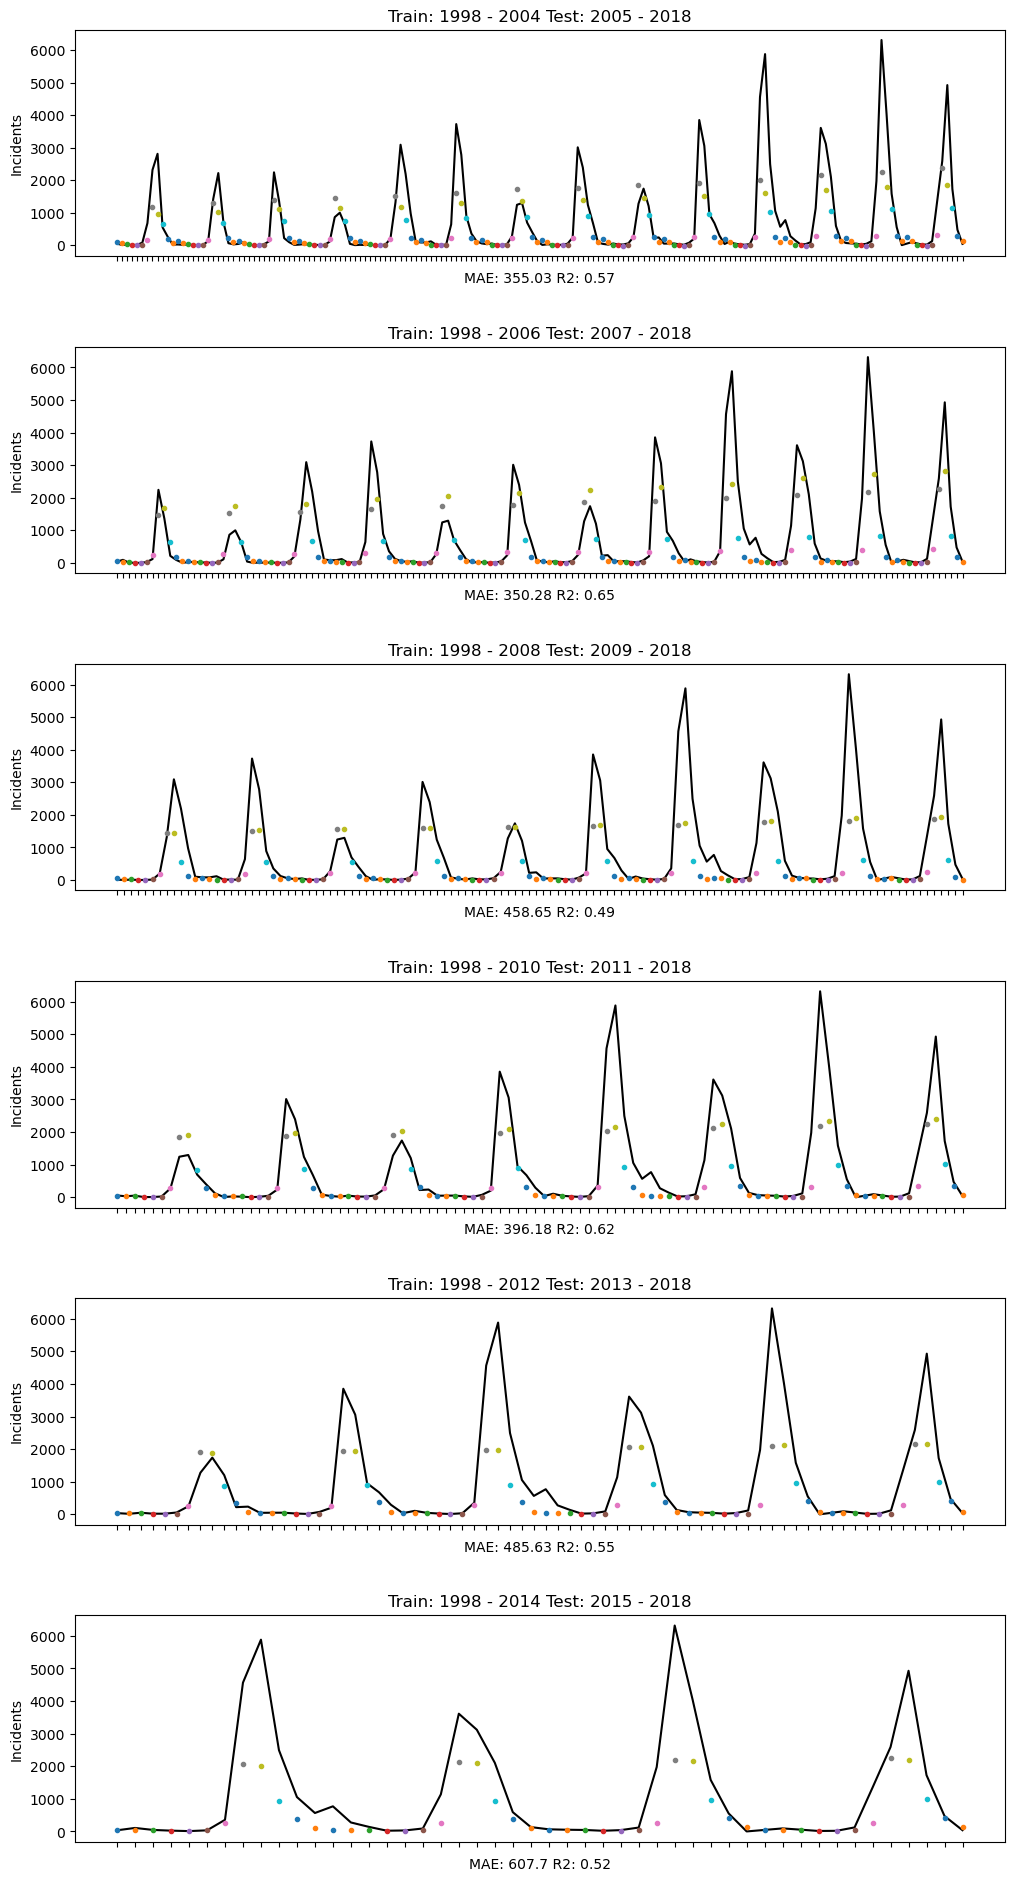

In [6]:
plt.rcParams['figure.figsize'] = [12, 4*6]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams['figure.subplot.hspace'] = 0.4 

fig, axs = plt.subplots(6)

model_maes, model_r2s = [], []
i = 0
for cut_year in range(2005, 2017, 2):
    X_train, X_test = X.loc[X['year'] < cut_year], X[X['year'] >= cut_year]
    y_train, y_test = y.loc[X['year'] < cut_year], y[X['year'] >= cut_year]
    
    axs[i].plot(np.array(clean_x_axis(X_test)), y_test, '-', label=f"Dados Reais", color="Black")
    
    maes, ys, ycs = [], [], []
    
    for month in range(1, 13, 1):
        lr = Ridge(5, normalize=True)
        lr.fit(X_train.loc[X_train['month'] == month], y_train.loc[X_train['month'] == month])
    
        y_predicted = lr.predict(X_test.loc[X_test['month'] == month])
        
        for k in range(len(y_test.loc[X_test['month'] == month])):
            ys.append(y_test.loc[X_test['month'] == month].values[k])
            ycs.append(y_predicted[k])
            
        maes.append(mean_absolute_error(y_test.loc[X_test['month'] == month], y_predicted))
        
        axs[i].plot(np.array(clean_x_axis(X_test.loc[X_test['month'] == month])), y_predicted, '.', label=f"{month}")

    axs[i].axes.xaxis.set_ticklabels([])

    axs[i].set_title(f"Train: 1998 - {cut_year - 1} Test: {cut_year} - 2018")
    axs[i].set_ylabel("Incidents")
    axs[i].set_xlabel(f"MAE: {np.round(np.mean(maes), 2)} R2: {np.round(r2_score(ys, ycs), 2)}")
    model_maes.append(np.round(np.mean(maes), 2))
    model_r2s.append(np.round(r2_score(ys, ycs), 2))
    i += 1

print(np.mean(model_maes), np.mean(model_r2s))

In [7]:
i = 0
for col in input_features:
    print(col, np.round(lr.coef_[0][i], 2), np.round(lr.coef_[0][i] * (state[col].max()-state[col].min()), 2))
    i += 1

year 1.75 31.53
month 0.0 0.0
incidents_expanding_mean 0.07 30.5
